In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [14]:
train_file = "./train.csv"
test_file = "./test.csv"

In [15]:
dfTrain = pd.read_csv(train_file)
dfTest = pd.read_csv(test_file)
df = pd.concat([dfTrain,dfTest], sort=False)

In [20]:
len(df.columns)

59

In [18]:
len(dfTrain.columns)

59

In [19]:
len(dfTest.columns)

58

In [21]:
num_cols = [
    "ps_reg_01", "ps_reg_02", "ps_reg_03",
    "ps_car_12", "ps_car_13", "ps_car_14", "ps_car_15"
]

ignore_cols = [
    "id", "target",
    "ps_calc_01", "ps_calc_02", "ps_calc_03", "ps_calc_04",
    "ps_calc_05", "ps_calc_06", "ps_calc_07", "ps_calc_08",
    "ps_calc_09", "ps_calc_10", "ps_calc_11", "ps_calc_12",
    "ps_calc_13", "ps_calc_14",
    "ps_calc_15_bin", "ps_calc_16_bin", "ps_calc_17_bin",
    "ps_calc_18_bin", "ps_calc_19_bin", "ps_calc_20_bin"
]

In [22]:
len(num_cols)

7

In [23]:
len(ignore_cols)

22

In [24]:
len(df.columns) - len(ignore_cols)

37

In [5]:
feature_dict = {}
total_feature = 0
for col in df.columns:
    if col in ignore_cols:
        continue
    elif col in num_cols:
        feature_dict[col] = total_feature
        total_feature += 1
    else:
        unique_val = df[col].unique()
        feature_dict[col] = dict(zip(unique_val,range(total_feature,len(unique_val) + total_feature)))
        total_feature += len(unique_val)

In [6]:
train_y = dfTrain[['target']]

In [7]:
dfTrain.drop(['target','id'],axis=1,inplace=True)
train_feature_index = dfTrain.copy()
train_feature_value = dfTrain.copy()

for col in train_feature_index.columns:
    if col in ignore_cols:
        train_feature_index.drop(col,axis=1,inplace=True)
        train_feature_value.drop(col,axis=1,inplace=True)
        continue
    elif col in num_cols:
        train_feature_index[col] = feature_dict[col]
    else:
        train_feature_index[col] = train_feature_index[col].map(feature_dict[col])
        train_feature_value[col] = 1

In [8]:
total_feature

257

In [9]:
tmp = df.drop(['target','id'],axis=1)
tmp.shape

(1488028, 57)

In [10]:
train_feature_index.shape

(595212, 37)

In [11]:
dfTest.drop(['target','id'],axis=1,inplace=True)
test_feature_index = dfTest.copy()
test_feature_value = dfTest.copy()

for col in test_feature_index.columns:
    if col in ignore_cols:
        test_feature_index.drop(col,axis=1,inplace=True)
        test_feature_value.drop(col,axis=1,inplace=True)
        continue
    elif col in num_cols:
        test_feature_index[col] = feature_dict[col]
    else:
        test_feature_index[col] = test_feature_index[col].map(feature_dict[col])
        test_feature_value[col] = 1

KeyError: "['target'] not found in axis"

In [ ]:
test_feature_index.shape

In [10]:
train_y.head(5)

,target
0,0
1,0
2,0
3,0
4,0


In [11]:
dataset = tf.data.Dataset.from_tensor_slices((train_feature_index.values, 
                                              train_feature_value.values,
                                              train_y.values))
#for idx, val, label in dataset.take(1):
#    print('idx: {}, val: {}, label: {}'.format(idx, val, label))

In [12]:
class DeepFM(tf.keras.Model):
    def __init__(self, cfg):
        super(DeepFM, self).__init__()
        self.feature_size = cfg['feature_size']
        self.field_size = cfg['field_size']
        self.embed_size = cfg['embed_size']
        self.deep_nn = cfg['deep_nn']
        
        self.dropout_fm = cfg['dropout_fm']
        self.dropout_deep = cfg['dropout_deep']
        
        # fm        
        self.feature_weight = tf.keras.layers.Embedding(cfg['feature_size'], 1)
        self.feature_embed = tf.keras.layers.Embedding(cfg['feature_size'], cfg['embed_size'])

        # dnn
        for layer in range(len(cfg['deep_nn'])):
            setattr(self, 'dense_' + str(layer), tf.keras.layers.Dense(self.deep_nn[layer]))
            setattr(self, 'batchNorm_' + str(layer), tf.keras.layers.BatchNormalization())
            setattr(self, 'activation_' + str(layer), tf.keras.layers.Activation('relu'))
            setattr(self, 'dropout_' + str(layer), tf.keras.layers.Dropout(self.dropout_deep))
            
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True)

    def call(self, feature_idx, feature_val):
        reshaped_feature_val = tf.cast(tf.reshape(feature_val, shape=[-1,self.field_size,1]), tf.float32)
        # linear        
        weights = self.feature_weight(feature_idx)
        linear = tf.reduce_sum(tf.multiply(weights,reshaped_feature_val),2)
        
        # fm  
        embeddings = self.feature_embed(feature_idx)
        second_inner = tf.multiply(embeddings,reshaped_feature_val)
        
        summed_features_emb = tf.reduce_sum(second_inner,1)
        summed_features_emb_square = tf.square(summed_features_emb)
        
        squared_features_emb = tf.square(second_inner)
        squared_sum_features_emb = tf.reduce_sum(squared_features_emb,1)
        
        fm = 0.5 * tf.subtract(summed_features_emb_square,squared_sum_features_emb)
        
        # dnn
        y_deep = tf.reshape(embeddings,shape=[-1,self.field_size * self.embed_size])
        for layer in range(0, len(self.deep_nn)):
            y_deep = getattr(self, 'dense_' + str(layer))(y_deep)
            y_deep = getattr(self, 'batchNorm_' + str(layer))(y_deep)
            y_deep = getattr(self, 'activation_' + str(layer))(y_deep)
            y_deep = getattr(self, 'dropout_' + str(layer))(y_deep)
            
        # concat
        concat = tf.concat([linear, fm, y_deep], axis=1)                                
        out = self.fc(concat)
        return out

In [28]:
cfg = {
    "feature_size": total_feature,
    "field_size": len(train_feature_index.columns),
    "embed_size":8,
    "deep_nn":[32,32],
    "dropout_fm": 0,
    "dropout_deep": 0.2,
    "epoch":20,
    "batch":10000
}

In [29]:
def train(input, cfg):
    model = DeepFM(cfg)
    loss_val = []
    train = input.shuffle(10000).batch(cfg['batch'])
    for epoch in range(int(cfg['epoch'])):
        batch_idx = 0
        for idx, val, label in train:
            with tf.GradientTape() as tape:
                y = model(idx, val)
                bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
                loss = bce(y_true=label, y_pred=y)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            batch_idx += 1
            # tf.print('batch_idx:', batch_idx, 'loss:', loss)
        loss_val.append(loss)
        tf.print("Epoch {}/{}　Loss: {}".format(epoch, cfg['epoch'], loss))
    return loss_val

In [30]:
loss_val = train(dataset, cfg)

Epoch 0/20　Loss: 0.9300224184989929
Epoch 1/20　Loss: 0.8796793222427368
Epoch 2/20　Loss: 0.8209131956100464
Epoch 3/20　Loss: 0.7631147503852844
Epoch 4/20　Loss: 0.7206069827079773
Epoch 5/20　Loss: 0.7007134556770325
Epoch 6/20　Loss: 0.6945783495903015
Epoch 7/20　Loss: 0.6933578848838806
Epoch 8/20　Loss: 0.6931819319725037
Epoch 9/20　Loss: 0.6931560039520264
Epoch 10/20　Loss: 0.6931505799293518
Epoch 11/20　Loss: 0.6931488513946533
Epoch 12/20　Loss: 0.693148136138916
Epoch 13/20　Loss: 0.6931478977203369
Epoch 14/20　Loss: 0.6931476593017578
Epoch 15/20　Loss: 0.693147599697113
Epoch 16/20　Loss: 0.6931475400924683
Epoch 17/20　Loss: 0.6931474208831787
Epoch 18/20　Loss: 0.6931474208831787
Epoch 19/20　Loss: 0.6931473612785339


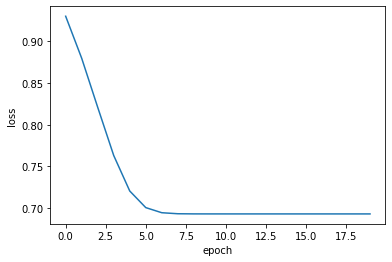

In [31]:
from matplotlib import pyplot as plt

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot([i for i in range(cfg['epoch'])], loss_val)
plt.show()